# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [1]:
%pip install --user scikit-learn --upgrade
import sklearn
print(sklearn.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 89.9 MB/s eta 0:00:00:00:010:01
Note: you may need to restart the kernel to use updated packages.
0.24.1


In [2]:
import numpy as np
import pandas as pd
import math

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

from IPython.display import display

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
907,0,19.0,37800.0,2,0
1830,0,22.0,44100.0,1,0
1121,0,33.0,38500.0,2,0
4052,0,32.0,48700.0,2,0
1892,0,29.0,37000.0,1,0
2345,0,25.0,49400.0,1,0
4943,1,41.0,44100.0,0,0
1698,0,33.0,41200.0,1,0
4629,1,31.0,29800.0,0,0
669,0,37.0,44900.0,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial

# escribe tu conversión aquí si lo deseas:
df['age'] = df['age'].astype(int)

In [8]:
# comprueba que la conversión se haya realizado con éxito
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [9]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.# ¿Se ve todo bien?
print(df.describe())

            gender          age        income  family_members  \
count  5000.000000  5000.000000   5000.000000     5000.000000   
mean      0.499000    30.952800  39916.360000        1.194200   
std       0.500049     8.440807   9900.083569        1.091387   
min       0.000000    18.000000   5300.000000        0.000000   
25%       0.000000    24.000000  33300.000000        0.000000   
50%       0.000000    30.000000  40200.000000        1.000000   
75%       1.000000    37.000000  46600.000000        2.000000   
max       1.000000    65.000000  79000.000000        6.000000   

       insurance_benefits  
count         5000.000000  
mean             0.148000  
std              0.463183  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              0.000000  
max              5.000000  


Valores únicos en 'gender': [1 0]


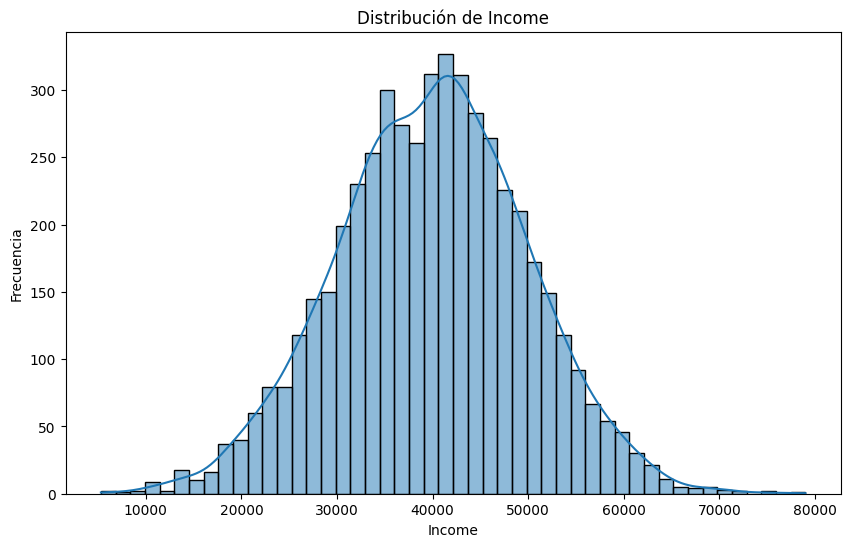

Conteo de valores en 'family_members':
1    1814
0    1513
2    1071
3     439
4     124
5      32
6       7
Name: family_members, dtype: int64


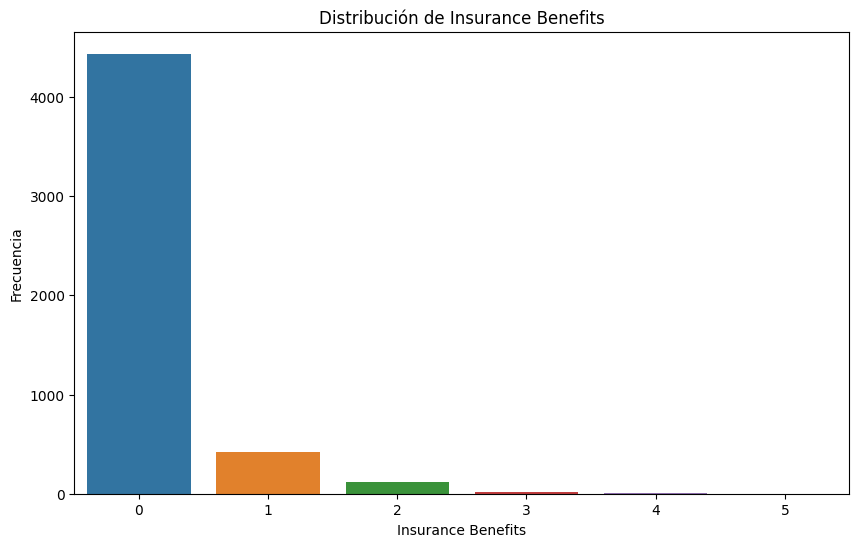

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Valores únicos en 'gender':", df['gender'].unique())

# Punto 2: Visualizar la distribución de `income`
plt.figure(figsize=(10, 6))
sns.histplot(df['income'], kde=True)
plt.title('Distribución de Income')
plt.xlabel('Income')
plt.ylabel('Frecuencia')
plt.show()

# Punto 3: Contar valores en `family_members` para revisar si hay clientes con 0 familiares
print("Conteo de valores en 'family_members':")
print(df['family_members'].value_counts())

# Punto 4: Visualizar la distribución de `insurance_benefits` para observar el desbalance
plt.figure(figsize=(10, 6))
sns.countplot(x='insurance_benefits', data=df)
plt.title('Distribución de Insurance Benefits')
plt.xlabel('Insurance Benefits')
plt.ylabel('Frecuencia')
plt.show()

# Conclusiones de las variables descriptivas

Gender: Solo contiene valores como 0 y 1, esto confirmaría que es una variable binaria.

Distribución de Income: La distribución es bastante simétrica y tiene una ligera asimetría hacia la derecha

Family Members: Hay un número considerable de clientes con 0 familiares (1,513 registros), lo cual es un dato a tener en cuenta.

Distribución de Insurance Benefits: La mayoría de los clientes (más de 4,000) no han recibido ningún beneficio de seguro. Esto indica un desbalance significativo en la variable objetivo (insurance_benefits)

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

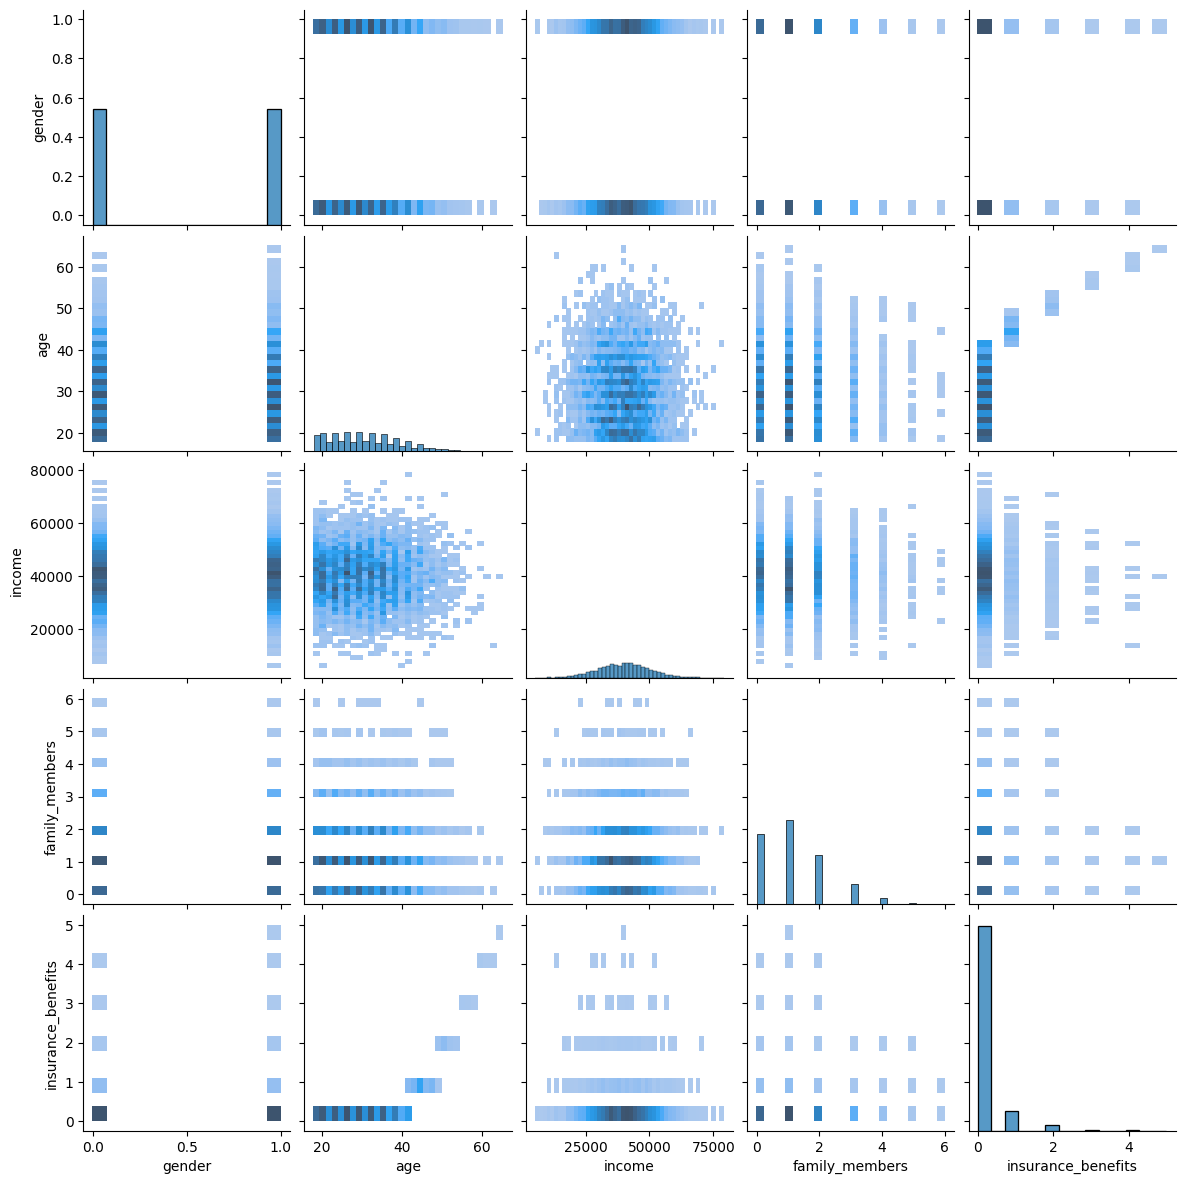

In [11]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.
Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.
Pruébalo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [12]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [13]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    
    :param n: número de objetos para los que se buscan los vecinos más cercanos    
    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names].values)
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names].values], return_distance=True)
    
    # Creación de un DataFrame con los resultados
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalar datos.

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [15]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
893,0.0,0.615385,0.694937,0.666667,0
339,1.0,0.830769,0.448101,0.000000,2
1408,0.0,0.538462,0.478481,0.000000,0
676,1.0,0.569231,0.788608,0.166667,0
1687,0.0,0.492308,0.405063,0.333333,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [16]:
# Ejemplo de uso: encontrar los 5 vecinos más cercanos al cliente en el índice 0 usando distancia Euclidiana en el conjunto escalado
n = 0  # Índice del cliente para el cual queremos encontrar vecinos
k = 5  # Número de vecinos más cercanos
metric = "euclidean"  # Métrica de distancia

# Obtener vecinos
result = get_knn(df_scaled, n, k, metric)
print(result)

      gender       age    income  family_members  insurance_benefits  distance
0        1.0  0.630769  0.627848        0.166667                   0  0.000000
2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
133      1.0  0.615385  0.636709        0.166667                   0  0.017754
4869     1.0  0.646154  0.637975        0.166667                   1  0.018418
3275     1.0  0.646154  0.651899        0.166667                   1  0.028550


In [17]:
n = 0  # Índice del cliente para el cual queremos encontrar vecinos
k = 5  # Número de vecinos más cercanos
metric = "manhattan"  # Métrica de distancia

# Obtener vecinos usando distancia Manhattan
result = get_knn(df_scaled, n, k, metric)
print(result)

      gender       age    income  family_members  insurance_benefits  distance
0        1.0  0.630769  0.627848        0.166667                   0  0.000000
2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
133      1.0  0.615385  0.636709        0.166667                   0  0.024245
4869     1.0  0.646154  0.637975        0.166667                   1  0.025511
3365     1.0  0.630769  0.596203        0.166667                   0  0.031646


Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Si, la importancia del escalado de los datos afecta el rendimiento del algoritmo. Sin escalado, las características con valores numéricos más grandes son las que  el algoritmo kNN podría priorizar y pueden que pierdan la influencia de las características con valores más pequeños

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

Los resultados en su mayoría son similares aunque pueden variar un poco como en este caso los 4 vecinos mas cercanos son los mismo aunque el quinto cambia, además las madidas de algunas distancias tambien cambian ya que  los valores de distancia serán diferentes debido a la forma en que cada métrica mide la distancia. La métrica Euclidiana mide la distancia directa en el espacio (en diagonal), mientras que Manhattan mide la distancia "en línea recta", sumando las distancias en cada dimensión.

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [18]:
# сalcula el objetivo
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)

In [19]:
# comprueba el desequilibrio de clases con value_counts()

# <tu código aquí>
print("Distribución de la variable objetivo (insurance_benefits_received):")
print(df['insurance_benefits_received'].value_counts())

Distribución de la variable objetivo (insurance_benefits_received):
0    4436
1     564
Name: insurance_benefits_received, dtype: int64


In [20]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    cm = confusion_matrix(y_true, y_pred)
    print('Matriz de confusión')
    print(cm)

In [21]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [22]:
for P in [df['insurance_benefits_received'].mean(), 0.5, 1]:
    print(f'Probabilidad de predicción aleatoria: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df['insurance_benefits_received']))
    
    # Evaluar el modelo aleatorio
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    print()

Probabilidad de predicción aleatoria: 0.11
F1: 0.12
Matriz de confusión
[[3957  479]
 [ 497   67]]

Probabilidad de predicción aleatoria: 0.50
F1: 0.20
Matriz de confusión
[[2280 2156]
 [ 265  299]]

Probabilidad de predicción aleatoria: 1.00
F1: 0.20
Matriz de confusión
[[   0 4436]
 [   0  564]]



In [23]:
# Definición de los datos y el objetivo
X = df[feature_names]
y = df['insurance_benefits_received']

# Divición de los datos en conjuntos de entrenamiento y prueba (70% - 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalamiento de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
# Evaluar kNN en datos sin escalar
print("Resultados con datos sin escalar:")
for k in range(1, 11):
    print(f"Modelo kNN con k={k}")
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    eval_classifier(y_test, y_pred_knn)
    print()

Resultados con datos sin escalar:
Modelo kNN con k=1
F1: 0.65
Matriz de confusión
[[1312   27]
 [  70   91]]

Modelo kNN con k=2
F1: 0.38
Matriz de confusión
[[1336    3]
 [ 123   38]]

Modelo kNN con k=3
F1: 0.39
Matriz de confusión
[[1325   14]
 [ 119   42]]

Modelo kNN con k=4
F1: 0.16
Matriz de confusión
[[1334    5]
 [ 147   14]]

Modelo kNN con k=5
F1: 0.17
Matriz de confusión
[[1325   14]
 [ 145   16]]

Modelo kNN con k=6
F1: 0.09
Matriz de confusión
[[1338    1]
 [ 153    8]]

Modelo kNN con k=7
F1: 0.12
Matriz de confusión
[[1337    2]
 [ 151   10]]

Modelo kNN con k=8
F1: 0.02
Matriz de confusión
[[1339    0]
 [ 159    2]]

Modelo kNN con k=9
F1: 0.04
Matriz de confusión
[[1339    0]
 [ 158    3]]

Modelo kNN con k=10
F1: 0.04
Matriz de confusión
[[1339    0]
 [ 158    3]]



In [25]:
# Evaluar kNN en datos escalados
print("Resultados con datos escalados:")
for k in range(1, 11):
    print(f"Modelo kNN con k={k}")
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_knn_scaled = knn.predict(X_test_scaled)
    eval_classifier(y_test, y_pred_knn_scaled)
    print()

Resultados con datos escalados:
Modelo kNN con k=1
F1: 0.93
Matriz de confusión
[[1332    7]
 [  14  147]]

Modelo kNN con k=2
F1: 0.92
Matriz de confusión
[[1336    3]
 [  22  139]]

Modelo kNN con k=3
F1: 0.94
Matriz de confusión
[[1334    5]
 [  15  146]]

Modelo kNN con k=4
F1: 0.91
Matriz de confusión
[[1337    2]
 [  24  137]]

Modelo kNN con k=5
F1: 0.94
Matriz de confusión
[[1334    5]
 [  14  147]]

Modelo kNN con k=6
F1: 0.91
Matriz de confusión
[[1337    2]
 [  24  137]]

Modelo kNN con k=7
F1: 0.94
Matriz de confusión
[[1335    4]
 [  16  145]]

Modelo kNN con k=8
F1: 0.91
Matriz de confusión
[[1338    1]
 [  25  136]]

Modelo kNN con k=9
F1: 0.93
Matriz de confusión
[[1337    2]
 [  18  143]]

Modelo kNN con k=10
F1: 0.92
Matriz de confusión
[[1338    1]
 [  22  139]]



# Conclusión

**Impacto del escalado:** El escalado de los datos tiene un cambio muy norotio en los resultados y rendimiento del modelo KNN, además que los datos sin escala el rendimeinto disminuye rapidamente a medida que aumenta el K. 

**Valor óptimo de k:** Para los datos escalados, los valores de k=3, k=5, y k=7 parecen ofrecer un rendimiento óptimo con un F1-score de 0.94.

# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [26]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y) # <tu código aquí>

    def predict(self, X):
        
        # añadir las unidades
        X2 = np.append(np.ones((len(X), 1)), X, axis=1) # <tu código aquí>
        y_pred = X2.dot(self.weights) # <tu código aquí>
        
        return y_pred

In [27]:
def eval_regressor(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    print(f"RMSE: {rmse:.2f}")
    
    r2 = r2_score(y_true, y_pred)
    print(f"R2: {r2:.2f}") 

In [28]:
# Definir X e y
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

# Crear el modelo de regresión lineal y entrenarlo
lr = MyLinearRegression()
lr.fit(X_train, y_train)
print("Pesos del modelo:", lr.weights)

# Predecir y evaluar en el conjunto de prueba
y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

# Escalado de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo en datos escalados y evaluar
lr.fit(X_train_scaled, y_train)
y_test_pred_scaled = lr.predict(X_test_scaled)
print("\nEvaluación en datos escalados:")
eval_regressor(y_test, y_test_pred_scaled)

Pesos del modelo: [-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.43

Evaluación en datos escalados:
RMSE: 0.34
R2: 0.43


# Conclusión:

En este caso en particular el escalar los datos no presenta ningún cambio en los resultados, lo cual es una observación útil sobre la naturaleza de los datos y la relación entre las características y el objetivo.

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [29]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [30]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [31]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [32]:
if np.linalg.det(P) == 0:
    print("La matriz P no es invertible. Genera una nueva matriz.")
else:
    print("La matriz P es invertible.")

    # Ocultar los datos 
X_ofuscado = X @ P

La matriz P es invertible.


¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

No se pueden adivinar ya al invertir una matriz aleatoria P se alteran los valores originales de manera significativa por lo que no se podria adivinar de manera exacta, a menos que conozcas la matriz 𝑃 para invertir la transformación.

¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

Si es posible recuperar los datos originales, esto se puede realizar aplicando la matriz inversa y utilizando la formula correspondiente para este paso, la cual es x= x . P -1

Muestra los tres casos para algunos clientes- Datos originales
- El que está transformado- El que está invertido (recuperado)

In [33]:
# Calculo de la matriz inversa de P
P_inv = np.linalg.inv(P)

# Recuperación los datos originales de X_ofuscado
X_recuperado = X_ofuscado @ P_inv

# Mostrar los tres casos: Datos originales, transformados y recuperados
print("Datos originales:\n", X[:3])
print("Datos transformados (X'):\n", X_ofuscado[:3])
print("Datos recuperados:\n", X_recuperado[:3])

Datos originales:
 [[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]]
Datos transformados (X'):
 [[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]]
Datos recuperados:
 [[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]]


Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

Esto se debe a la menera en que las bibliotecas almacen los datos ya que se pierden decimales en el proceso ya que los datos son almacenados  con precisión finita y no infinita como las matematicas.

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

**¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior?**

Los pesos 𝑤 y 𝑤𝑃 están relacionados por la matriz de ofuscación P,  en otras palabras, wP es una transformación lineal de w mediada por 𝑃−1.

**¿Cuáles serían los valores predichos con $w_P$?** 
los valores predichos, 𝑦^𝑃, son idénticos a los valores predichos con los datos originales 𝑦^. La transformación no cambia los resultados de la predicción.

**¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?**
La ofuscación no alteran los resultados de la predicción lineal ya que el error cuadrático medio (ECM) y la raíz del error cuadrático medio (RECM) permanecen iguales, logrando así proteger los datos sin afectar el rendimiento del modelo.

Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**Respuesta**

**Prueba analítica**

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

In [34]:
np.random.seed(42)
P = np.random.rand(X.shape[1], X.shape[1])

# Comprobación de si P es invertible
if np.linalg.det(P) == 0:
    print("La matriz P no es invertible. Genera una nueva matriz.")
else:
    print("La matriz P es invertible.")


La matriz P es invertible.


In [35]:
 X_ofuscado = X @ P

In [36]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse_original = np.sqrt(mean_squared_error(y_test, y_pred))
r2_original = r2_score(y_test, y_pred)

# Aplicación de regresión lineal a los datos ofuscados
model.fit(X_train @ P, y_train) 
y_pred_ofuscado = model.predict(X_test @ P)
rmse_ofuscado = np.sqrt(mean_squared_error(y_test, y_pred_ofuscado))
r2_ofuscado = r2_score(y_test, y_pred_ofuscado)

# Resultados
print(f"Resultados con datos originales: RMSE = {rmse_original:.2f}, R2 = {r2_original:.2f}")
print(f"Resultados con datos ofuscados: RMSE = {rmse_ofuscado:.2f}, R2 = {r2_ofuscado:.2f}")

Resultados con datos originales: RMSE = 0.34, R2 = 0.43
Resultados con datos ofuscados: RMSE = 0.34, R2 = 0.43


Estos resultados muestran que la ofuscación mediante multiplicación con una matriz invertible P no afectó la calidad de la regresión lineal.

# Conclusiones

En base a las actividades realizadas en este proyecto podemos resaltar las siguientes conclusiónes:
**1° La importancia del escalado de caracteristicas para el modelo (kNN):** Hubo una gran diferencia positiva al escala los datos en la presición del modelo por lo que resalto como el preprocesamiento adecuado puede mejorar la precisión y confiabilidad de los modelos.
**2° Eficiencia de la Ofuscación de Datos:** La técnica de ofuscación utilizada, mediante la multiplicación con una matriz invertible, logró proteger los datos sin adectar la precisión en los modelos de regresión lineal ya que se comprobo que se obtuvieron los mismos resultados y se mantuvo intacta las relaciones lineales, por lo que se garantiza un modelo bien elaborado y seguro , por lo que se puede trabajar con datos sensibles de una manera segura sin afectar los resultados logrando un **balance entre Privacidad y Precisión**

# Apéndices

## Apéndice A: Escribir fórmulas en los cuadernos de Jupyter

Puedes escribir fórmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicación de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las fórmulas se verán como las de los libros de texto.

Para incorporar una fórmula a un texto, pon el signo de dólar (\\$) antes y después del texto de la fórmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una fórmula debe estar en el mismo párrafo, pon el doble signo de dólar (\\$\\$) antes y después del texto de la fórmula, por ejemplo:
$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan fórmulas en sus artículos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en inglés) de dos páginas para aprender a componer las fórmulas más comunes.

## Apéndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al álgebra lineal. Aquí se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba analítica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicación</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposición de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>